In [22]:
import os
import cv2
import pandas as pd
import numpy as np
import random
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from skimage.feature import hog
from PIL import Image
from skimage import io, feature, color, exposure
from skimage.io import imread, imshow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
def read_data(data_dir):
  # Initialize lists for images, labels
  images = []
  labels = []
  classes = {'normal': 0, 'benign': 1, 'malignant' : 2}

  for class_name, class_label in classes.items():
      class_dir = os.path.join(data_dir, class_name)
      for image_file in os.listdir(class_dir):
          if image_file.endswith(".png") and 'mask' not in image_file:
              # Load the original image
              image_path = os.path.join(class_dir, image_file)
              images.append(image_path)

              class_label = classes[class_name]
              labels.append(class_label)

  return images, labels

  # Function to apply Local Binary Pattern (LBP) algorithm
def compute_lbps(images):
    lbps = []
    for image_path in images:
        # Load the original image
        image = io.imread(image_path)

        # Compute LBP for the image
        lbp_image = feature.local_binary_pattern(color.rgb2gray(image), P=8, R=1, method='uniform')
        lbp_image = np.expand_dims(lbp_image, axis = -1)
        lbps.append(lbp_image)

    return lbps

def compute_hogs(images):
    hogs = []
    for image_path in images:
        # Load the original image
        image = io.imread(image_path)
        # Compute HOG for the image
        fd, hog_image = feature.hog(
            image,
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            visualize=True,
            channel_axis=-1,
        )
        # Optionally, rescale intensity for better visualization
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        # Append the HOG features to the list
        hogs.append(hog_image_rescaled)

    return hogs

In [3]:
# Assuming you have already called read_data to get images, masks, and labels
data_dir = "/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/Original without duplicated, misclassification and axila/balanced_data"
images, labels = read_data(data_dir)

In [5]:
# Compute LBP images separately
lbps = compute_lbps(images)

# Compute HOG images separately
hogs = compute_hogs(images)

In [7]:
# Creating dataframe from the generated lists
df = pd.DataFrame({'images': images, 'lbps': lbps, 'hogs': hogs, 'labels': labels})

train_data, test_data = train_test_split(df, test_size = 0.2, random_state=42, stratify=df['labels'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print("Unique labels in training set:", train_data['labels'].unique())
print("Unique labels in test set:", test_data['labels'].unique())

Unique labels in training set: [2 0 1]
Unique labels in test set: [0 2 1]


In [9]:
height, width, channels = 128, 128, 3

# Initialize empty arrays for X_train and y_train
X_train_image = np.zeros((len(train_data), height, width, channels), dtype=np.uint8)
X_train_lbp = np.zeros((len(train_data), height, width, 1), dtype=np.uint8)
X_train_hog = np.zeros((len(train_data), height, width, 1), dtype=np.uint8)
y_train = np.zeros(len(train_data), dtype=np.uint8)

# Iterate through the DataFrame to populate X_train and y_train
for idx, row in train_data.iterrows():
    image_path = row['images']
    lbp = row['lbps']
    hog = row['hogs']
    label_train = row['labels']

    # Load and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))

    # Load and resize the LBP image
    lbp_resized = cv2.resize(lbp, (width, height))
    # Add a singleton dimension to make it (height, width, 1)
    lbp_resized = np.expand_dims(lbp_resized, axis=-1)

    # Load and resize the HOG image
    hog_resized = cv2.resize(hog, (width, height))
    # Add a singleton dimension to make it (height, width, 1)
    hog_resized = np.expand_dims(hog_resized, axis=-1)

    X_train_image[idx] = image
    X_train_lbp[idx] = lbp_resized
    X_train_hog[idx] = hog_resized
    y_train[idx] = label_train


In [10]:
height, width, channels = 128, 128, 3

# Initialize empty arrays for X_train and y_train
X_test_image = np.zeros((len(test_data), height, width, channels), dtype=np.uint8)
X_test_lbp = np.zeros((len(test_data), height, width, 1), dtype=np.uint8)
X_test_hog = np.zeros((len(test_data), height, width, 1), dtype=np.uint8)
y_test = np.zeros(len(test_data), dtype=np.uint8)

# Iterate through the DataFrame to populate X_train and y_train
for idx, row in test_data.iterrows():
    image_path = row['images']
    lbp = row['lbps']
    hog = row['hogs']
    label_test = row['labels']

    # Load and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))

    # Load and resize the LBP image
    lbp_resized = cv2.resize(lbp, (width, height))
    # Add a singleton dimension to make it (height, width, 1)
    lbp_resized = np.expand_dims(lbp_resized, axis=-1)

    # Load and resize the HOG image
    hog_resized = cv2.resize(hog, (width, height))
    # Add a singleton dimension to make it (height, width, 1)
    hog_resized = np.expand_dims(hog_resized, axis=-1)

    X_test_image[idx] = image
    X_test_lbp[idx] = lbp_resized
    X_test_hog[idx] = hog_resized
    y_test[idx] = label_test

In [17]:
print(X_test_image.shape)
print(X_test_lbp.shape)
print(X_test_hog.shape)
print(y_test.shape[0])

(179, 128, 128, 3)
(179, 128, 128, 1)
(179, 128, 128, 1)
179


In [12]:
unet = load_model('/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/best_models/segmentation/hog+lbp_original_unet.h5')

In [18]:
# Predict using X_train and X_test
preds_train = unet.predict([X_train_image, X_train_lbp, X_train_hog], verbose =1)
preds_test = unet.predict([X_test_image, X_test_lbp, X_test_hog], verbose =1)

# Threshold the predicted mask to create binary masks
preds_train_mask = (preds_train > 0.5).astype(np.uint8)
preds_test_mask = (preds_test > 0.5).astype(np.uint8)

6/6 [==============================] - 9s 2s/step


In [20]:
print(preds_train.shape)
print(preds_test.shape)

(715, 128, 128, 1)
(179, 128, 128, 1)


In [30]:
# Resizing to (197, 197)
new_size = (197, 197)

# Calculate zoom factors
zoom_factors = (new_size[0] / X_train_image.shape[1], new_size[1] / X_train_image.shape[2])

# Resize X_train_image
X_train_image_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in X_train_image])
X_test_image_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in X_test_image])

# Resize X_train_lbp, X_train_hog, preds_train_mask
X_train_lbp_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in X_train_lbp])
X_train_hog_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in X_train_hog])
preds_train_mask_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in preds_train_mask])

X_test_lbp_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in X_test_lbp])
X_test_hog_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in X_test_hog])
preds_test_mask_resized = np.array([ndimage.zoom(img, zoom_factors + (1,), order=1) for img in preds_test_mask])

# Verify the shapes
print("X_train_image_resized shape:", X_train_image_resized.shape)
print("X_train_lbp_resized shape:", X_train_lbp_resized.shape)
print("X_train_hog_resized shape:", X_train_hog_resized.shape)
print("preds_train_mask_resized shape:", preds_train_mask_resized.shape)


X_train_image_resized shape: (715, 197, 197, 3)
X_train_lbp_resized shape: (715, 197, 197, 1)
X_train_hog_resized shape: (715, 197, 197, 1)
preds_train_mask_resized shape: (715, 197, 197, 1)


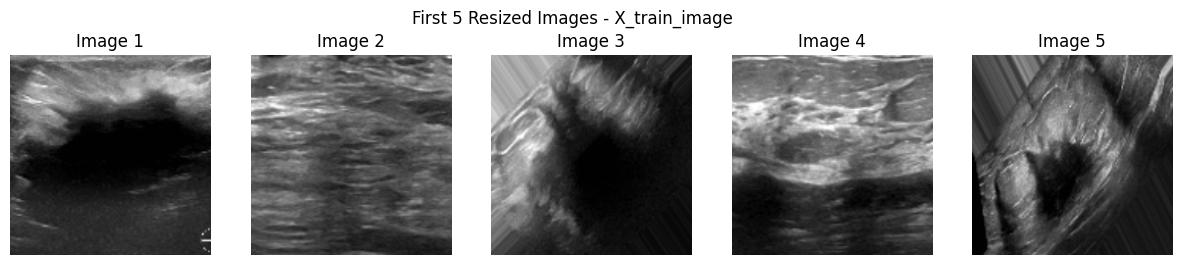

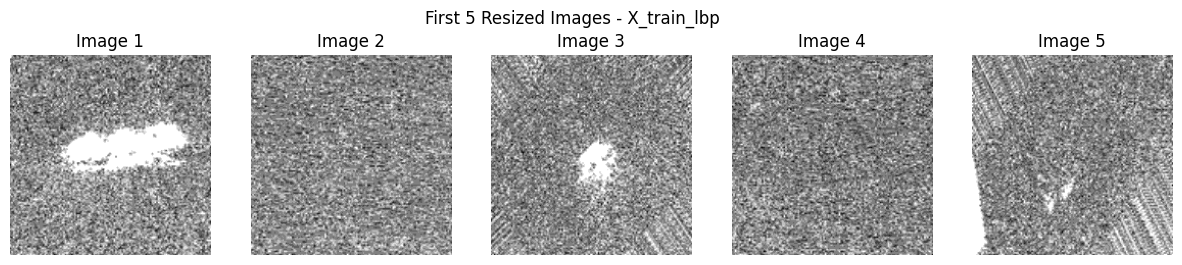

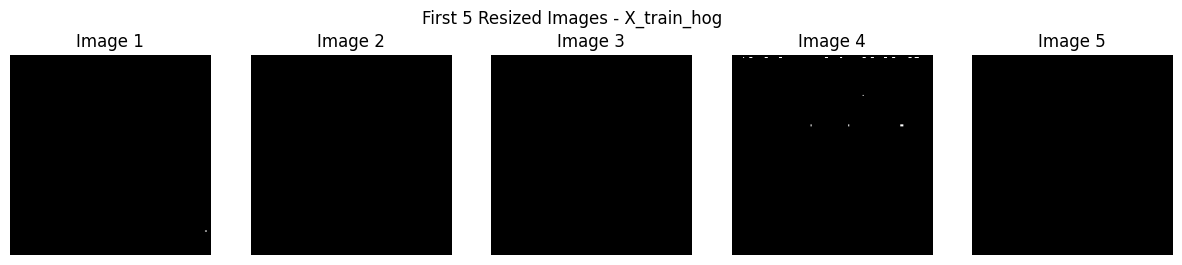

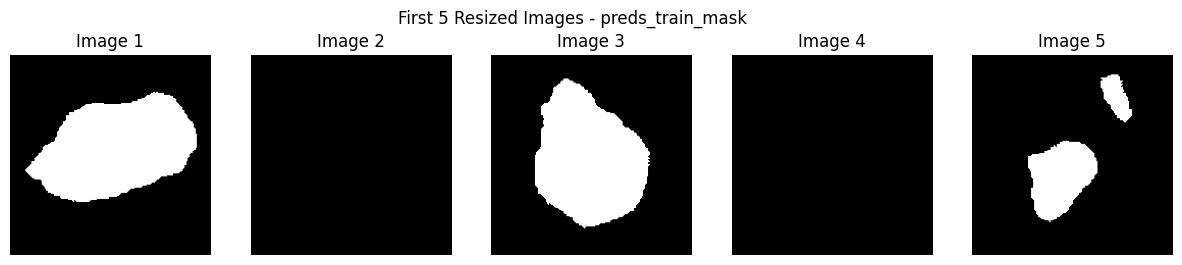

In [31]:
categories = ['X_train_image', 'X_train_lbp', 'X_train_hog', 'preds_train_mask']

for category, data in zip(categories, [X_train_image_resized, X_train_lbp_resized, X_train_hog_resized, preds_train_mask_resized]):
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"First 5 Resized Images - {category}")

    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(data[i, :, :, 0], cmap='gray')  # Assuming grayscale images
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.show()

### Classification Models/CNN/Transfer Learning


In [32]:
batch_size = 8
learning_rate = 0.0001
epochs = 100


In [33]:
num_classes = 3
# Convert labels to one-hot encoding for categorical_crossentropy loss
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [34]:
# Assuming your data shapes
image_shape = (197, 197, 3)
lbp_shape = (197, 197, 1)
hog_shape = (197, 197, 1)
mask_shape = (197, 197, 1)
num_classes = 3

# Define input layers for each type of data
inputs_image = Input(shape=image_shape, name='image_input')
inputs_lbp = Input(shape=lbp_shape, name='lbp_input')
inputs_hog = Input(shape=hog_shape, name='hog_input')
inputs_mask = Input(shape=mask_shape, name='mask_input')

X_train_image_processed = preprocess_input(X_train_image_resized)
X_test_image_processed = preprocess_input(X_test_image_resized)

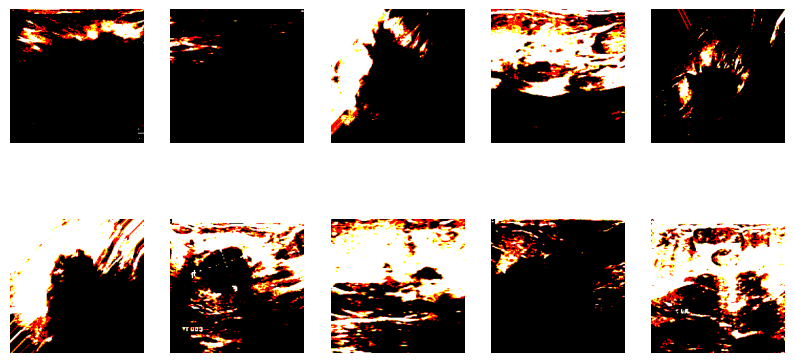

In [35]:
# Visualize the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(2):
    for j in range(5):
        axes[i, j].imshow(X_train_image_processed[i * 5 + j])
        axes[i, j].axis('off')

plt.show()

In [37]:

# Add ResNet-50 base
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)
resnet_base.trainable = False
resnet_output = resnet_base(inputs_image)
resnet_output = GlobalAveragePooling2D()(resnet_output)  # Use Global Average Pooling to reduce dimensions

# Flatten the LBP and HOG inputs
flattened_lbp = GlobalAveragePooling2D()(inputs_lbp)
flattened_hog = GlobalAveragePooling2D()(inputs_hog)
flattened_mask = GlobalAveragePooling2D()(inputs_mask)

# Concatenate the outputs from ResNet-50, LBP, and HOG
concatenated = Concatenate()([resnet_output, flattened_lbp, flattened_hog, flattened_mask])

# Custom layers with dropout
x = Dense(32, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer with softmax activation for multiclass classification
output_layer = Dense(num_classes, activation='softmax')(x)

In [38]:
# Create the model
model = Model(inputs=[inputs_image, inputs_lbp, inputs_hog, inputs_mask], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical crossentropy for multiclass problems
              metrics=['accuracy'])

# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 197, 197, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['image_input[0][0]']         
                                                          2                                       
                                                                                                  
 lbp_input (InputLayer)      [(None, 197, 197, 1)]        0         []                            
                                                                                                  
 hog_input (InputLayer)      [(None, 197, 197, 1)]        0         []                        

In [39]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/classification_pretrainedResNet50_orig+lbp+hog+mask.h5', verbose = 1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs/Class_ResNet50_all4/')
]

In [ ]:
# Train the model with the defined architecture and callbacks
history = model.fit(
    [X_train_image_processed, X_train_lbp_resized, X_train_hog_resized, preds_train_mask_resized],  # Your training data
    y_train,  # One-hot encoded labels
    validation_split=0.1,
    batch_size=batch_size,
    epochs = 100,
    callbacks=callbacks
    )

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.7474 - accuracy: 0.6687
Epoch 1: val_loss improved from inf to 0.53256, saving model to /content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/classification_pretrainedResNet50_orig+lbp+hog+mask.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 130s 2s/step - loss: 0.7474 - accuracy: 0.6687 - val_loss: 0.5326 - val_accuracy: 0.7639
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8149
Epoch 2: val_loss did not improve from 0.53256
81/81 [==============================] - 123s 2s/step - loss: 0.4602 - accuracy: 0.8149 - val_loss: 0.6136 - val_accuracy: 0.7778
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.8507
Epoch 3: val_loss improved from 0.53256 to 0.45394, saving model to /content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/models/classification_pretrainedResNet50_orig+lbp+hog+mask.h5
81/81 [==============================] - 110s 1s/step - loss: 0.3712 - accuracy: 0.8507 - val_loss: 0.4539 - val_accuracy: 0.8194
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8740

In [ ]:
preds_cnn = model.predict([X_test_image_processed, X_test_lbp_resized, X_test_hog_resized, preds_test_mask_resized], verbose =1)



6/6 [==============================] - 28s 4s/step


In [ ]:
# Convert predictions to class labels (assuming a classification task)
predicted_classes = np.argmax(preds_cnn, axis=1)
# Convert one-hot encoded labels to categorical labels
y_test_categorical = np.argmax(y_test, axis=1)

In [ ]:
# Calculate accuracy for the test set
accuracy_test = accuracy_score(y_test_categorical, predicted_classes)
classification_result = classification_report(y_test_categorical, predicted_classes)
print("Accuracy on Test Set:", accuracy_test)
print("Classification Report on Test Set:", classification_result)

Accuracy on Test Set: 0.8491620111731844
Classification Report on Test Set:               precision    recall  f1-score   support

           0       0.89      0.86      0.88        59
           1       0.83      0.90      0.86        60
           2       0.82      0.78      0.80        60

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



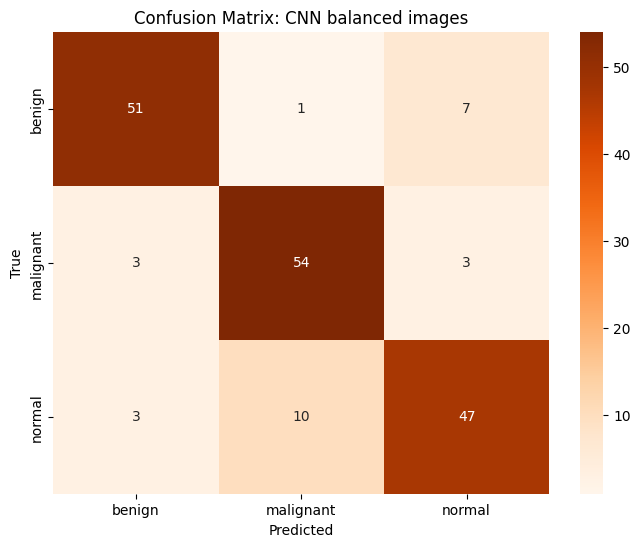

In [ ]:
# Create a confusion matrix
confusion = confusion_matrix(y_test_categorical, predicted_classes)

categories = {'benign':1, 'malignant':2, 'normal':0}

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Oranges', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: CNN balanced images')
plt.show()